# What are 2-Point Spatial Correlations (also called 2-Point Statistics)?
This example computes both periodic and non-periodic 2-point spatial correlations (also referred to as 2-point stats or auto-correlations and cross-correlations) for a checkerboard microstructure. This is a simple example to demonstrate how spatial correlations capture features seen in the original microstructure. More technical details about 2-point statistics are in the theory section.

taken from http://pymks.org/en/stable/rst/notebooks/checkerboard.html

In [1]:
import numpy as np
from sklearn.pipeline import Pipeline

from pymks import (
    generate_checkerboard,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation
)

In [2]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

%matplotlib inline
%load_ext autoreload
%autoreload 2

Start with a 8x8 microstructure as a useful tool for seeing correlations

In [3]:
x_data = generate_checkerboard(
    size=(21 * 8, 21 * 8),
    square_shape=(21, 21)
).persist()

(1, 168, 168)


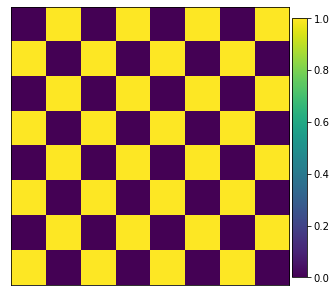

In [4]:
plot_microstructures(x_data[0])
print(x_data.shape)

or we can do it on any generic image we'd like

In [15]:
from PIL import Image
  
# open method used to open different extension image file
im = Image.open(r"C:\Users\taylo\Google Drive\teaching\5050 Materials Informatics\MaterialsInformatics\worked_examples\2_pt_statistics_example\custom3.jpg") 
  
# This method will show image in any image viewer 
#im.show() 

# asarray() class is used to convert
# PIL images into NumPy arrays
numpydata = np.asarray(im)
thresh = 200
fn = lambda x : 255 if x > thresh else 0
r = im.convert('L').point(fn, mode='1')  
numpydata = np.asarray(r)
print(numpydata.shape)
x_data=numpydata
y = np.expand_dims(x_data, axis=0)
print(y.shape)
x_data = y


(280, 280)
(1, 280, 280)


## Compute Periodic 2-Point Statistics
Compute the periodic 2-points stats using the TwoPointCorrelation class. The periodic_boundary argument is set to True. To compute 2-point stats first discretize the microstructure using a chosen basis using a PrimitiveTransformer with n_state equal to 2. The PrimitiveTransformer and the TwoPointCorrelation are combined into a Scikit-learn pipeline to generate a model. The transform method executes the pipeline as this is not a model that requires a predict step to use.

In [16]:
model = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ('correlations', TwoPointCorrelation(
        periodic_boundary=True,
        cutoff=x_data.shape[1],
        correlations=[[0, 0], [1, 1], [0, 1]]
    ))
])

print(x_data.shape)
x_stats = model.transform(x_data).persist()
print(x_stats.shape)

(1, 280, 280)
(1, 279, 279, 3)


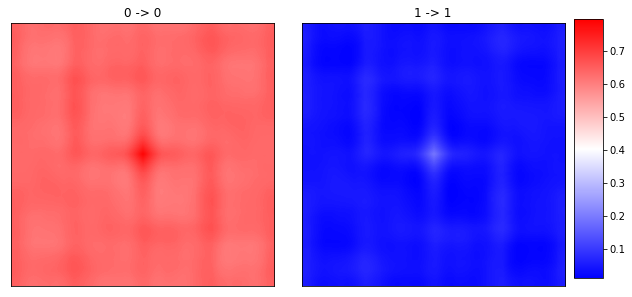

In [17]:
plot_microstructures(x_stats[0, :, :, 0], x_stats[0, :, :, 1], titles=['0 -> 0', '1 -> 1'], cmap='bwr');


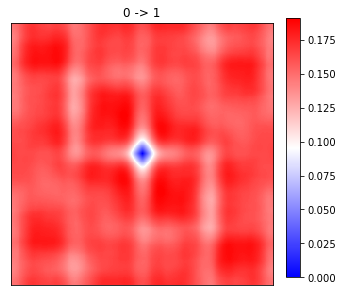

In [18]:
plot_microstructures(x_stats[0, :, :, 2], titles=['0 -> 1'], cmap='bwr');


In [19]:
center = x_stats.shape[1] // 2

print('Volume fraction of 0 -> 0: ', np.allclose(x_stats[0, center, center, 0], 0.5))
print('Volume fraction of 0 -> 1: ', np.allclose(x_stats[0, center, center, 2], 0))

Volume fraction of 0 -> 0:  dask.array<all-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>
Volume fraction of 0 -> 1:  dask.array<all-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>


## Compute Non-Periodic 2-Point Statistics
Compute the non-periodic 2-point statistics for the microstructure, but with non-periodic statistics by setting the periodic_boundary=False.

In [20]:
model = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ('correlations', TwoPointCorrelation(
        periodic_boundary=False,
        cutoff=x_data.shape[1],
        correlations=[[0, 0], [1, 1], [0, 1]]
    ))
])

x_stats = model.transform(x_data).persist()
x_stats.shape

(1, 279, 279, 3)

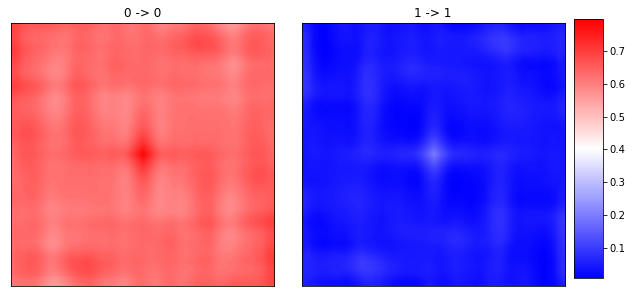

In [21]:
plot_microstructures(x_stats[0, :, :, 0], x_stats[0, :, :, 1], titles=['0 -> 0', '1 -> 1'], cmap='bwr');


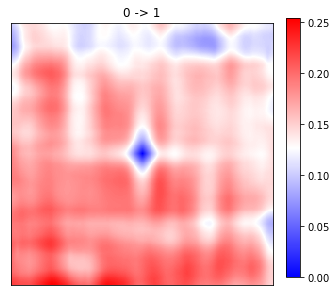

In [22]:
plot_microstructures(x_stats[0, :, :, 2], titles=['0 -> 1'], cmap='bwr');


In [23]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print('Volume fraction of black phase', x_stats[0, center, center, 0].compute())
print('Volume fraction of white phase', x_stats[0, center, center, 1].compute())

Volume fraction of black phase 0.6222959183673464
Volume fraction of white phase 0.37770408163265284


In [34]:
assert np.allclose(x_stats[0, center, center, 0], 0.5)
assert np.allclose(x_stats[0, center, center, 1], 0.5)

AssertionError: 